Introduction
---
We will be looking into the store sales data from Corporacion Favorita[https://www.corporacionfavorita.com/en/], an Ecuadorian company with various sub-brand retailer chains under their commercial arm which provide grocery products to its consumers.

The dataset comes from kaggle[https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data], which is part of a kaggle competition.

Main Objective of this project
---
To help the company to forecast the sales between 16/08/2017 to 31/08/2017 using the data given from period 01/01/2013 to 15/08/2017.

Dataset we will be using for the intial review
---

Holidays - File contains the date, holiday_type, the hierarchy of holiday(national, regional or local), description of holidays. Analysing holiday file can possibly provide us some insights on whether holidays would drive up sales so that the forecast would be more accruate.

Oil - File contains the daily oil price up till the test dates. Ecuador was mentioned to be an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices. We will be investigating to see if there are any relationship between oil prices and Favorita's sales.

Stores - File contains store number, city, state, type, and cluster. Store's location and layout may potentially affect sales. We will be looking at some of the data and how it would be useful to help predict sales.

Train - Training set contains the store number, type of categories, on-going promotion, and their respective sales per store per date. Analysing which poducts are mostly sold in the stores can also help us to finetune the required supplies to stock up in order to meet the sales demand.

Transactions - File contains total transactions per store per date.

Approach for this project
---
A. Exploratory Data Analysis
-
1. High level review of the initial datasets
2. Combine and clean up dataset to gather insights from analysis

B. Prediction of sales

1. Prepare the training model dataset for machine learning (use one hot encoding for catergorical variables)
2. Prepare test dataset similar to the train dataset's approach
3. Choosing the type of ML model
4. Conclusion

A.1.1 High level review of the initial datasets
-

Importing of python libraries and importing the datasets from excel.csv

In [1]:
#importing python libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import datetime as dt

from pandas_profiling import ProfileReport

sns.set_style('whitegrid')

In [2]:
#importing from csv
holidays = pd.read_csv(r'C:\Users\admin\Desktop\Portfolio\Store Sales - Time Series Forecasting\holidays_events.csv')
oil = pd.read_csv(r'C:\Users\admin\Desktop\Portfolio\Store Sales - Time Series Forecasting\oil.csv')
stores = pd.read_csv(r'C:\Users\admin\Desktop\Portfolio\Store Sales - Time Series Forecasting\stores.csv')
test = pd.read_csv(r'C:\Users\admin\Desktop\Portfolio\Store Sales - Time Series Forecasting\test.csv')
train = pd.read_csv(r'C:\Users\admin\Desktop\Portfolio\Store Sales - Time Series Forecasting\train.csv')
transactions = pd.read_csv(r'C:\Users\admin\Desktop\Portfolio\Store Sales - Time Series Forecasting\transactions.csv')

In [3]:
#using pandas-profiling for review
profile_holiday = ProfileReport(holidays, minimal=True, title="Holiday file")
profile_oil = ProfileReport(oil, minimal=True, title="Oil file")
profile_stores = ProfileReport(stores, minimal=True, title="Stores file")
profile_test = ProfileReport(test, minimal=True, title="Test file")
profile_train = ProfileReport(train, minimal=True, title="Train file")
profile_transactions = ProfileReport(transactions, minimal=True, title="Transactions file")

profile_holiday.to_notebook_iframe()
profile_oil.to_notebook_iframe()
profile_stores.to_notebook_iframe()
profile_test.to_notebook_iframe()
profile_train.to_notebook_iframe()
profile_transactions.to_notebook_iframe()

Render HTML: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


Render HTML: 100%|██████████| 1/1 [00:00<00:00, 25.05it/s]


Render HTML: 100%|██████████| 1/1 [00:00<00:00, 13.74it/s]


Render HTML: 100%|██████████| 1/1 [00:00<00:00, 10.67it/s]


Render HTML: 100%|██████████| 1/1 [00:00<00:00,  5.83it/s]


Render HTML: 100%|██████████| 1/1 [00:00<00:00, 16.17it/s]


A.1.2 Summary from initial reviews of inidividual datasets
-
Overall dataset
-
All dates types have to be converted to datetime format in order to use the date columns.


Train - Train file date starts from 1/1/2013 and ends at 15/8/2017. There are also 33 unique cateogries of product sold in each stores.


Stores - There a total of 54 stores from Favorita across 22 cities/16 states of Ecuador. Notably, there are 18 stores operating in Quito, capital of Ecuador followed by 8 stores in Guayaquil, the second largest city in Ecuador. There are 5 types of stores layout (A to E) and 17 clusters in total.


Oil - Contains daily oil prices from 1/1/2013 till 31/8/31. However there are dates missing as the dates are not in sequences. Furthermore, there are some missing prices from the date as well. We will extrapolate the prices of the oil using average price per month on these missing values.


Holidays - There are a total of 5 different types of holidays. There are also repeated holidays within the same date as the distinct dates are 312 while the dataset contains 350 rows.

Some holidays are transfered. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12 and the day off is on 2012-10-12 as well. 

Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.

Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).


Transations - Transactions file date starts from 1/1/2013 and ends at 15/8/2017 and contains only total transactions per store by date.


Test - Continuation of Train file date starting from 16/8/2017 and ends at 31/8/2017.


Limitation on files
---

1. Some of the columns were not properly explained (i.e store_types / cluster info)
2. Time period for some dataset may not stretch all the way to 'test' dates

A.2.1 Combine and clean up dataset for analysis
---

A.2.1.1  Hypothesis #1: Relationship between time period and sales
-

Dataset:
'Train'

Problems:
1. Does not have the date split out into the respective day, month and year.
2. Information contains from 1/1/2013 to 15/8/2017.

Solution:
1. To convert date to datetime and subsequently split it into respective columns for analaysis.
2. Using average sales for the time period to look at the mean sales across the time period.

In [4]:
#converting 'date' column to datetime and spliting them out into various columns for analysis
train['date'] = pd.to_datetime(train['date'])
train['day'] = train['date'].dt.strftime("%a")
train['year'] = train['date'].dt.strftime("%Y").astype(int)
train['month'] = train['date'].dt.strftime("%m").astype(int)
train['day_date'] = train['date'].dt.strftime("%d").astype(int)

#function to label quarters
def fill_quarter(x):
    '''
    check number and return 'Q1' to 'Q4'
    '''
    if x <=3:
        return 'Q1'
    elif x<=6:
        return 'Q2'
    elif x<=9:
        return 'Q3'
    else:
        return 'Q4'

train['quarter'] = train['month'].apply(lambda x: fill_quarter(x))

In [5]:
train

,id,date,store_nbr,family,sales,onpromotion,day,year,month,day_date,quarter
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,Tue,2013,1,1,Q1
1,1,2013-01-01,1,BABY CARE,0.000,0,Tue,2013,1,1,Q1
2,2,2013-01-01,1,BEAUTY,0.000,0,Tue,2013,1,1,Q1
3,3,2013-01-01,1,BEVERAGES,0.000,0,Tue,2013,1,1,Q1
4,4,2013-01-01,1,BOOKS,0.000,0,Tue,2013,1,1,Q1
...,...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,Tue,2017,8,15,Q3
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Tue,2017,8,15,Q3
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,Tue,2017,8,15,Q3
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Tue,2017,8,15,Q3


Analysis on the dataset

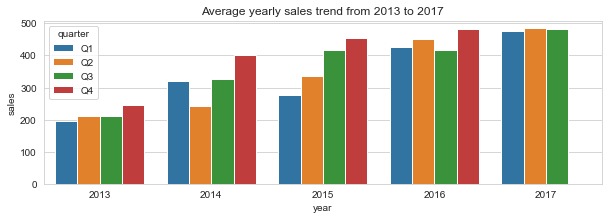

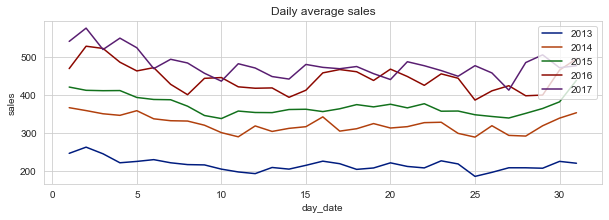

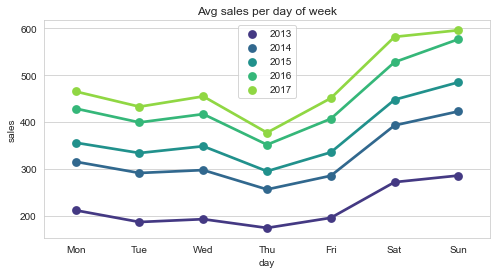

In [6]:
train_year_quarter = train.groupby(['year','quarter'], as_index=False).agg({'sales':'mean'})
plt.figure(figsize=(10,3))
plt.title('Average yearly sales trend from 2013 to 2017')
sns.barplot(data=train_year_quarter,x='year',y='sales', hue='quarter')
plt.show()

train_year_day_date = train.groupby(['year','day_date'], as_index=False).agg({'sales':'mean'})
plt.figure(figsize=(10,3))
plt.title('Daily average sales')
sns.lineplot(data=train_year_day_date,x='day_date',y='sales',hue='year', palette='dark')
plt.legend(loc='upper right')
plt.show()

train_day_year = train.groupby(['day','year'], as_index=False).agg({'sales':'mean'})
day_of_week=["Mon","Tue","Wed","Thu", "Fri","Sat","Sun"]
plt.figure(figsize=(8,4))
sns.pointplot(x='day', y='sales', hue='year', data=train_day_year, palette='viridis', order=day_of_week)
plt.title('Avg sales per day of week')
plt.legend(loc='upper center')
plt.show()

For relationship between time period* and sales, we can deduce the following:
1. Sales tend to increase progressively from Q1 to Q4, with Q4 being the highest in sales
2. Sales are usually highest between the period 30th of the month to 2nd of the following month
3. People tend to buy more products during the weekends as well
*Note: Information after 15/8/2017 are taken out to form 'test' set for the case compeition prediction purposes. There were no data provided for Q4 of 2017 as well.

The analysis shows that peopole tend to shop when they are free (aka weekends) and also during holiday / seasonal period. Favorita can consider stocking up their stores during these periods to meet the demand.

A.2.1.2 Hypothesis #2: Relationship between type/location and sales
-
Dataset:
'Train', 'Stores'

No major issue with the 'store' dataset. We will be merging the 'stores' and train set for analysis.

In [7]:
#renaming for ease of reference
stores.rename({'type': 'store_type'}, axis=1, inplace=True)

train_1 = pd.merge(train,stores,how='left',on='store_nbr')

In [8]:
train_1

,id,date,store_nbr,family,sales,onpromotion,day,year,month,day_date,quarter,city,state,store_type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,Tue,2013,1,1,Q1,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.000,0,Tue,2013,1,1,Q1,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.000,0,Tue,2013,1,1,Q1,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.000,0,Tue,2013,1,1,Q1,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.000,0,Tue,2013,1,1,Q1,Quito,Pichincha,D,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,Tue,2017,8,15,Q3,Quito,Pichincha,B,6
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Tue,2017,8,15,Q3,Quito,Pichincha,B,6
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,Tue,2017,8,15,Q3,Quito,Pichincha,B,6
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Tue,2017,8,15,Q3,Quito,Pichincha,B,6


Analysis on the dataset

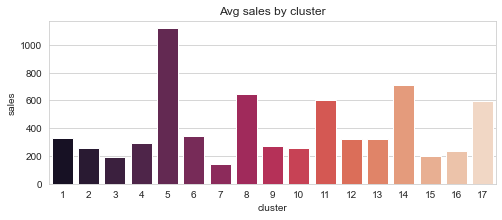

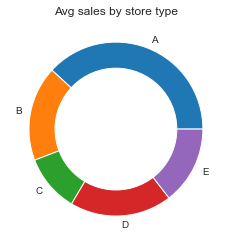

In [9]:
train_cluster = train_1.groupby('cluster', as_index=False).agg({'sales':'mean'})
plt.figure(figsize=(8,3))
sns.barplot(data=train_cluster,y='sales',x='cluster',palette='rocket')
plt.title('Avg sales by cluster')
plt.show()

train_storetype = train_1.groupby('store_type', as_index=False).agg({'sales':'mean'})
plt.title('Avg sales by store type')
my_circle = plt.Circle( (0,0), 0.7, color='white')

plt.pie(train_storetype['sales'], labels=train_storetype['store_type'])
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

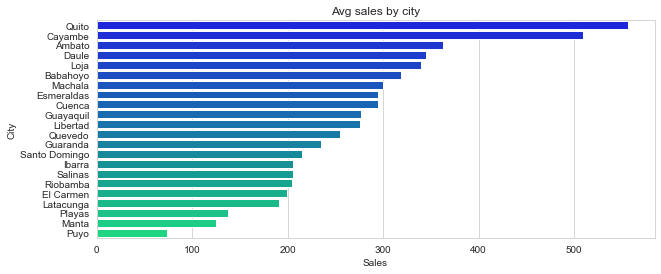

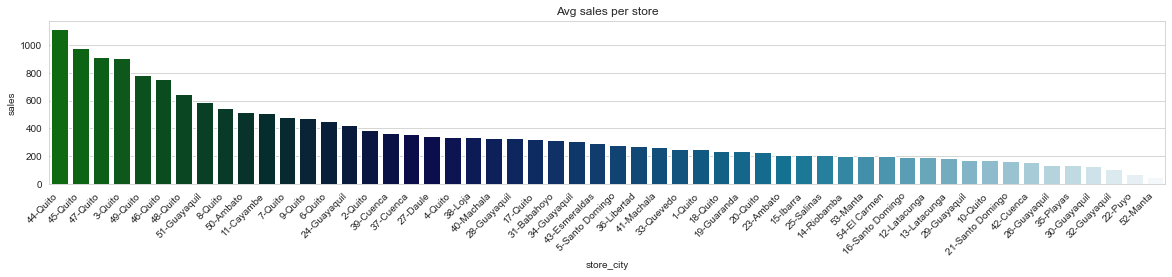

In [10]:
train_location = train_1.groupby('city', as_index=False).agg({'sales':'mean'}).sort_values('sales',ascending=False)
plt.figure(figsize=(10,4))
sns.barplot(data=train_location,y='city',x='sales',palette='winter')
plt.title('Avg sales by city')
plt.ylabel('City')
plt.xlabel('Sales')
plt.show()

train_1['store_city'] = train_1['store_nbr'].astype(str) + '-' + train_1['city']
train_stores_city = train_1.groupby(['store_city'], as_index=False).agg({'sales':'mean'}).sort_values('sales',ascending=False)
plt.figure(figsize=(20,3))
chart = sns.barplot(data=train_stores_city, y='sales', x='store_city', palette='ocean', order=train_stores_city['store_city'])
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Avg sales per store')
plt.show()

For relationship between types/location and sales, we can conclude the following:
1. Average sales tends to be highest if the store belongs to cluster '5' and 'A' type store.
2. It is no surprise that Quito, the capital of Ecuador has the highest sales. However, it is interesting to note that Cayambe came in 2nd being the highest average sales. Perhaps volcano hikes do attract alot of people and they buy alot of stuff to prepare themselves for the hike.

Favorita can consider closing poor performing stores (if they are not at least breaking even), relocate them to a better area and/or changing their store type to improve their sales.

A.2.1.3 Hypothesis #3: Relationships between holidays/events and sales
-
Dataset used:
'Train', 'Holidays', 'Stores'

Problems
1. 'Holidays' contains a mixed of actual holidays and events.
2. There are holidays which were not celebrated on the actual day but were transferred by the govt to be day off on another date.
3. Duplicates of holidays (350 rows but 312 distinct dates) within the same day which will cause issues when merged

Solutions:
1. To split out holidays and events before merging them into the train dataset
2. Re-algin the days where people spend their day off so that the prediction is more accruate
3. Remove duplicates prioritizing National > Regional > Local holidays if they falls on the same day

In [11]:
#function to replace NAN values from other columns
def replacing_method(aaa,bbb,ccc):
    if pd.isnull(aaa):
        if pd.isnull(bbb):
            return ccc
        else:
            return bbb
    else:
        return aaa

#converting holidays to datetime format
holidays['date'] = pd.to_datetime(holidays['date'])

#Change type 'Transfer' to Holiday as it is celebrated on that day
holidays['type'] = holidays['type'].replace(to_replace = 'Transfer', value='Holiday')

#Change type 'Holiday' where transferred = true to 'Work Day'
holidays['type'].mask(holidays['transferred'] == True, 'Work Day', inplace=True)

#Drop 'transferred' as it has been adjusted
holidays.drop(['transferred'],axis=1, inplace=True)
holidays.rename({'type': 'holiday_type'}, axis=1, inplace=True)

holidays_national = holidays[(holidays['locale']=='National')]
holidays_regional = holidays[(holidays['locale']=='Regional')]
holidays_local = holidays[(holidays['locale']=='Local')]

#filter only by non-events as events holiday type aren't really official holidays
holidays_national_1 = holidays_national[(holidays_national['holiday_type'] != 'Event')]

#Check duplicates
holidays_national_1[holidays_national_1.duplicated(['date'], keep=False)]
holidays_regional[holidays_regional.duplicated(['date'], keep=False)]
holidays_local[holidays_local.duplicated(['date'], keep=False)]

#drop duplicates
holidays_national_1 = holidays_national_1.drop_duplicates(subset=['date'], keep='first')

#drop the repeated holiday based on condition
holidays_local = holidays_local.drop(holidays_local[(holidays_local['holiday_type']=='Additional') & (holidays_local['date']=='2016-07-24')].index)

train_2 = pd.merge(train_1,holidays_national_1,how='left',on='date')

train_2 = pd.merge(train_2,holidays_regional,how='left',left_on=['date','state'], right_on=['date','locale_name'])
train_2.rename({'holiday_type_x': 'holiday_type_national', 
                'locale_x': 'locale_national', 
                'locale_name_x': 'locale_name_national',
                'description_x': 'description_national', 
                'holiday_type_y': 'holiday_type_regional', 
                'locale_y': 'locale_regional', 
                'locale_name_y': 'locale_name_regional', 
                'description_y': 'description_regional'}, 
                axis=1, inplace=True)

train_2 = pd.merge(train_2,holidays_local,how='left',left_on=['city', 'date'], right_on=['locale_name', 'date'])

train_2.rename({'holiday_type': 'holiday_type_local',
                'locale': 'locale_local', 
                'locale_name': 'locale_name_local', 
                'description': 'description_local'}, 
                axis=1, inplace=True)

#replacing NaN values with other columns
train_2['holiday_type_national'] = train_2.apply(lambda x: replacing_method(x['holiday_type_national'],x['holiday_type_regional'],x['holiday_type_local']),axis=1)
train_2['locale_national'] = train_2.apply(lambda x: replacing_method(x['locale_national'],x['locale_regional'],x['locale_local']),axis=1)
train_2['locale_name_national'] = train_2.apply(lambda x: replacing_method(x['locale_name_national'],x['locale_name_regional'],x['locale_name_local']),axis=1)
train_2['description_national'] = train_2.apply(lambda x: replacing_method(x['description_national'],x['description_regional'],x['description_local']),axis=1)

#drop the duplicated columns
train_2.drop(train_2.columns[-8:], axis=1, inplace=True)

#rename the columns
train_2.rename({'holiday_type_national': 'holiday_type', 
                'locale_national': 'locale', 
                'locale_name_national': 'locale_name',
                'description_national': 'description',},
                axis=1, inplace=True)

#filling in those columns which are not denote as holiday as 'Work Day'
train_2['holiday_type'] = train_2['holiday_type'].fillna('Work Day')
train_2['locale'] = train_2['locale'].fillna('None')
train_2['locale_name'] = train_2['locale_name'].fillna('None')
train_2['description'] = train_2['description'].fillna('None')

In [12]:
train_2

,id,date,store_nbr,family,sales,onpromotion,day,year,month,day_date,quarter,city,state,store_type,cluster,store_city,holiday_type,locale,locale_name,description
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,Tue,2013,1,1,Q1,Quito,Pichincha,D,13,1-Quito,Holiday,National,Ecuador,Primer dia del ano
1,1,2013-01-01,1,BABY CARE,0.000,0,Tue,2013,1,1,Q1,Quito,Pichincha,D,13,1-Quito,Holiday,National,Ecuador,Primer dia del ano
2,2,2013-01-01,1,BEAUTY,0.000,0,Tue,2013,1,1,Q1,Quito,Pichincha,D,13,1-Quito,Holiday,National,Ecuador,Primer dia del ano
3,3,2013-01-01,1,BEVERAGES,0.000,0,Tue,2013,1,1,Q1,Quito,Pichincha,D,13,1-Quito,Holiday,National,Ecuador,Primer dia del ano
4,4,2013-01-01,1,BOOKS,0.000,0,Tue,2013,1,1,Q1,Quito,Pichincha,D,13,1-Quito,Holiday,National,Ecuador,Primer dia del ano
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,Tue,2017,8,15,Q3,Quito,Pichincha,B,6,9-Quito,Work Day,None,None,None
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Tue,2017,8,15,Q3,Quito,Pichincha,B,6,9-Quito,Work Day,None,None,None
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,Tue,2017,8,15,Q3,Quito,Pichincha,B,6,9-Quito,Work Day,None,None,None
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Tue,2017,8,15,Q3,Quito,Pichincha,B,6,9-Quito,Work Day,None,None,None


In [13]:
#to include events as part of the data set
holidays_national_2 = holidays_national[(holidays_national['holiday_type'] =='Event')]

holidays_national_2.rename({'holiday_type':'event', 'description': 'event_description'}, inplace=True, axis=1)
holidays_national_2.drop(holidays_national_2[(['locale','locale_name'])], axis=1, inplace=True)

#check for duplicates and remove accordingly
holidays_national_2[holidays_national_2.duplicated(['date'], keep=False)]
holidays_national_2 = holidays_national_2.drop_duplicates(subset=['date'], keep='first')

train_2 = pd.merge(train_2,holidays_national_2,how='left',on='date')

#Changing the event column to either 'Yes' or 'No' and filling up the Nan with 'None' in description
train_2['event'] = train_2['event'].fillna('No')
train_2['event_description'] = train_2['event_description'].fillna('None')
train_2['event'] = train_2['event'].replace({'Event': 'Yes'})

C:\Users\admin\AppData\Local\Temp\ipykernel_14364\2777590304.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  holidays_national_2.rename({'holiday_type':'event', 'description': 'event_description'}, inplace=True, axis=1)
C:\Users\admin\AppData\Local\Temp\ipykernel_14364\2777590304.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  holidays_national_2.drop(holidays_national_2[(['locale','locale_name'])], axis=1, inplace=True)


In [14]:
train_2

,id,date,store_nbr,family,sales,onpromotion,day,year,month,day_date,...,state,store_type,cluster,store_city,holiday_type,locale,locale_name,description,event,event_description
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,Tue,2013,1,1,...,Pichincha,D,13,1-Quito,Holiday,National,Ecuador,Primer dia del ano,No,None
1,1,2013-01-01,1,BABY CARE,0.000,0,Tue,2013,1,1,...,Pichincha,D,13,1-Quito,Holiday,National,Ecuador,Primer dia del ano,No,None
2,2,2013-01-01,1,BEAUTY,0.000,0,Tue,2013,1,1,...,Pichincha,D,13,1-Quito,Holiday,National,Ecuador,Primer dia del ano,No,None
3,3,2013-01-01,1,BEVERAGES,0.000,0,Tue,2013,1,1,...,Pichincha,D,13,1-Quito,Holiday,National,Ecuador,Primer dia del ano,No,None
4,4,2013-01-01,1,BOOKS,0.000,0,Tue,2013,1,1,...,Pichincha,D,13,1-Quito,Holiday,National,Ecuador,Primer dia del ano,No,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,Tue,2017,8,15,...,Pichincha,B,6,9-Quito,Work Day,None,None,None,No,None
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Tue,2017,8,15,...,Pichincha,B,6,9-Quito,Work Day,None,None,None,No,None
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,Tue,2017,8,15,...,Pichincha,B,6,9-Quito,Work Day,None,None,None,No,None
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Tue,2017,8,15,...,Pichincha,B,6,9-Quito,Work Day,None,None,None,No,None


Analysis on the dataset

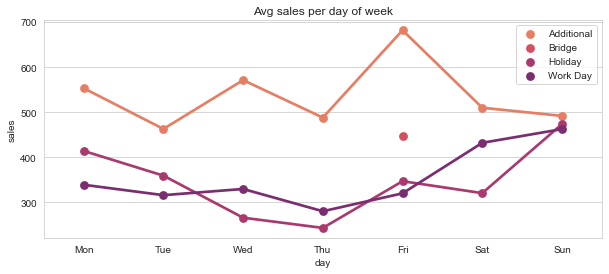

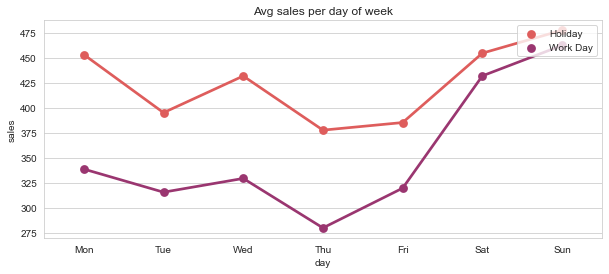

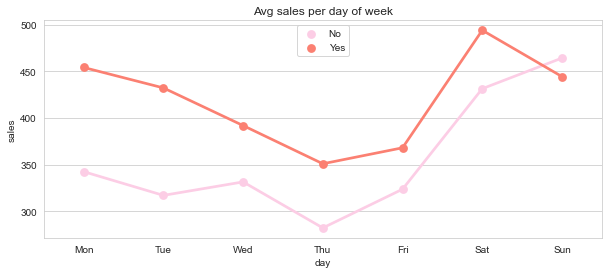

In [15]:
train_holidaytype_day = train_2.groupby(['day', 'holiday_type'], as_index=False).agg({'sales':'mean'})
day_of_week=["Mon","Tue","Wed","Thu", "Fri","Sat","Sun"]
plt.figure(figsize=(10,4))
sns.pointplot(x='day', y='sales', hue='holiday_type', data=train_holidaytype_day, palette='flare', order=day_of_week)
plt.title('Avg sales per day of week')
plt.legend(loc='upper right')
plt.show()

train_2_temp = train_2
train_2_temp['holiday_type'] = train_2_temp['holiday_type'].replace({'Bridge': 'Holiday', 'Additional': 'Holiday'})
train_holidaytype_day_1 = train_2_temp.groupby(['day', 'holiday_type'], as_index=False).agg({'sales':'mean'})
day_of_week=["Mon","Tue","Wed","Thu", "Fri","Sat","Sun"]
plt.figure(figsize=(10,4))
sns.pointplot(x='day', y='sales', hue='holiday_type', data=train_holidaytype_day_1, palette='flare', order=day_of_week)
plt.title('Avg sales per day of week')
plt.legend(loc='upper right')
plt.show()

train_holidaytype_day = train_2.groupby(['day', 'event'], as_index=False).agg({'sales':'mean'})
day_of_week=["Mon","Tue","Wed","Thu", "Fri","Sat","Sun"]
plt.figure(figsize=(10,4))
sns.pointplot(x='day', y='sales', hue='event', data=train_holidaytype_day, palette='Set3_r', order=day_of_week)
plt.title('Avg sales per day of week')
plt.legend(loc='upper center')
plt.show()

In [16]:
train_2[(train_2['holiday_type']=='Additional') & (train_2['day']=='Fri')]['description'].value_counts()

Series([], Name: description, dtype: int64)

In [17]:
train_2[(train_2['event']=='Yes') & (train_2['day']=='Sun')]['event_description']

233442     Dia de la Madre
233443     Dia de la Madre
233444     Dia de la Madre
233445     Dia de la Madre
233446     Dia de la Madre
                ...       
2835157    Dia de la Madre
2835158    Dia de la Madre
2835159    Dia de la Madre
2835160    Dia de la Madre
2835161    Dia de la Madre
Name: event_description, Length: 21384, dtype: object

For relationship between holidays and sales, we can deduce that the following:
1. Generally, days with holidays have a higher average sales compared to normal work days. The differences becomes less significant during weekend as it is not holiday but it is also not a regular work day.
2. Notably there was a sharp increase on average sales for 'Additional' type on Fri because it was due to "Navidad-2" on 24/12/20xx which was Christmas Eve.
3. The trends remains the same for events. The decrease on average sales for sun is due to the event being 'Dia de la Madre' or rather 'Mother's Day' in Ecuador, it probably suggest that people dine out to celerbate Mother's day rather than getting groceries to cook at home for that day.

A.2.1.4 Hypothesis #4: Relationships between oil prices and sales
-

There a couple of missing prices and dates within the 'Oil' dataset. Hence we would merge the 'Oil' dataset with 'train' and extrapolate using the avg monthly price of the oil for all those missing values.

Dataset:
'Train', 'Oil'

Problems
1. Missing oil prices on certain dates

Solutions:
1. Extrapolate the oil prices using average monthly price

In [18]:
oil['date'] = pd.to_datetime(oil['date'])
oil.rename({'dcoilwtico':'oil_price'}, inplace=True, axis=1)

train_3 = pd.merge(train_1,oil,how='left',on='date')

#creating a mon_year column
train_3['mon_year'] = train_3['date'].dt.strftime('%Y-%m')

#create an avg price dataset to merge and overwtite the original columns' Nan values.
avg_mth_price = train_3.groupby('mon_year').mean()['oil_price'].reset_index()
train_3 = pd.merge(train_3,avg_mth_price,how='left',on='mon_year')
train_3['oil_price_x'] = train_3['oil_price_x'].fillna(train_3['oil_price_y'])
train_3.drop(train_3[(['mon_year','oil_price_y'])], axis=1, inplace=True)
train_3.rename({'oil_price_x':'oil_price'}, inplace=True, axis=1)

In [78]:
oil

,date,oil_price
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
...,...,...
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96


Analysis on dataset

Text(0, 0.5, 'Oil Price')

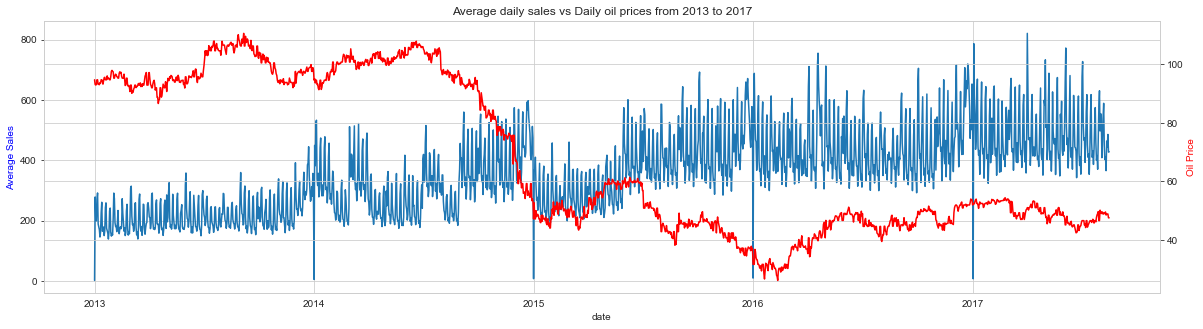

In [19]:
train_oil = train_3.groupby(['date'], as_index=False).agg({'sales':'mean', 'oil_price':'mean'})
plt.figure(figsize=(20,5))
plt.title('Average daily sales vs Daily oil prices from 2013 to 2017')

ax1 = plt.subplot()
ax2 = ax1.twinx()
sns.lineplot(data=train_oil, x='date', y='sales', ax=ax1)
sns.lineplot(data=train_oil, x='date', y='oil_price', color='r', ax=ax2)
ax1.set_ylabel('Average Sales', color='b')
ax2.set_ylabel('Oil Price', color='r')

Ecuador is a oil-dependent country, the consumption of goods should have some correlation to oil prices. From the graph, there are only some correlation between Oil prices and sales trend for Favorita stores as the daily average sales continues to grow year on year despite the flucuation of oil prices. This could be due to the goods that Favorita are selling necessities which are mostly inelastic where any changes in income/price would not affect their sales greatly. 

A.2.1.5 Hypothesis #5: Relationships between transactions and sales
-
Dataset:
'Transaction', 'Train'

Problems
1. Missing transactions data for 'test' time period
2. Transaction data only have overall transactions of sales per store per date and no breakdown of the individual transactions per family items.

Solutions:
1. Left join 'Train' to 'Transactions'

In [20]:
transactions['date'] = pd.to_datetime(transactions['date'])
train_date_store = train.groupby(['date','store_nbr']).sum()['sales'].reset_index()
transactions_sales = pd.merge(transactions,train_date_store,how='left',on=['date','store_nbr'])

In [21]:
transactions_sales.corr()

,store_nbr,transactions,sales
store_nbr,1.000000,0.189311,0.216148
transactions,0.189311,1.000000,0.837384
sales,0.216148,0.837384,1.000000


Relationship between transactions and sales are rather straight-forward. Higher sales leads to higher transactions.

A.2.1.5 Hypothesis #6: Other relationships to explore vs sales
-

Product and sales
-

Text(0.5, 0, 'Sales')

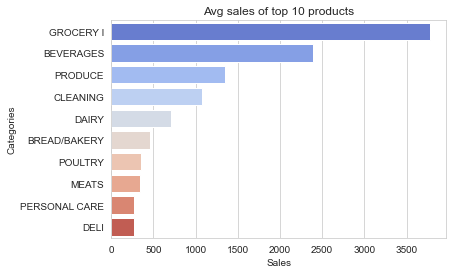

In [22]:
train_family = train.groupby(['family'], as_index=False).agg({'sales':'mean'}).sort_values('sales',ascending=False).head(10)
sns.barplot(data=train_family,y='family',x='sales',palette='coolwarm')
plt.title('Avg sales of top 10 products')
plt.ylabel('Categories')
plt.xlabel('Sales')

The average sales of top 10 most products are shown in the graph above. It is natural to see that basic necessasities are the top purchase in the supermarket.

Promotions and sales
-

In [23]:
def replacing_promotion(aaa):
    if aaa == 0:
        return 'No'
    else:
        return 'Yes'

train_temp = train
#using the created function to replace 0 with 'No' and any other figures to 'Yes'
train_temp['onpromotion'] = train_temp.apply(lambda x: replacing_promotion(x['onpromotion']), axis=1)

Text(0.5, 0, 'Promotion')

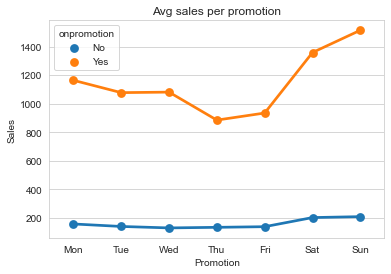

In [24]:
train_promotion = train_temp.groupby(['onpromotion','day'], as_index=False).agg({'sales':'mean'})
sns.pointplot(data=train_promotion,y='sales',x='day', hue='onpromotion', order=day_of_week)
plt.title('Avg sales per promotion')
plt.ylabel('Sales')
plt.xlabel('Promotion')

Items on promotion tends to attract more sales. This is more prominent during weekends where the sales difference is huge for items with and without promotions.

B.1.1 Preparing dataset for training model
-

With EDA explored, we will now select the features we want to be included in our training model.

They are as follows:
1. Time period
2. Stores types
3. Location
4. Holidays and Events
5. Type of products
6. Promotions
7. Oil prices

We will not be including transactions as it does not have information for the period within the 'test' set.

In [ ]:
extracted_oil_price = train_3['oil_price']
train_2 = train_2.join(extracted_oil_price)

In [ ]:
#dropping columns that are not required
X = train_2.drop(train_2[(['id','date','sales','quarter','state','store_city','locale_name','description','event_description'])], axis=1)
y = train_2['sales']

In [42]:
X

,store_nbr,family,onpromotion,day,year,month,day_date,city,store_type,cluster,holiday_type,locale,event,oil_price
0,1,AUTOMOTIVE,0,Tue,2013,1,1,Quito,D,13,Holiday,National,No,94.756667
1,1,BABY CARE,0,Tue,2013,1,1,Quito,D,13,Holiday,National,No,94.756667
2,1,BEAUTY,0,Tue,2013,1,1,Quito,D,13,Holiday,National,No,94.756667
3,1,BEVERAGES,0,Tue,2013,1,1,Quito,D,13,Holiday,National,No,94.756667
4,1,BOOKS,0,Tue,2013,1,1,Quito,D,13,Holiday,National,No,94.756667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,9,POULTRY,0,Tue,2017,8,15,Quito,B,6,Work Day,None,No,47.570000
3000884,9,PREPARED FOODS,1,Tue,2017,8,15,Quito,B,6,Work Day,None,No,47.570000
3000885,9,PRODUCE,148,Tue,2017,8,15,Quito,B,6,Work Day,None,No,47.570000
3000886,9,SCHOOL AND OFFICE SUPPLIES,8,Tue,2017,8,15,Quito,B,6,Work Day,None,No,47.570000


Importing relevant scikit learn packages for machine learning
-

In [60]:
#importing relevant sklearn packages
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

Creating a pipeline to preprocess of both numerical and categorical features and train the dataset subsequently
-

In [49]:
#Using standard scaler on numerical features
num_features = ['onpromotion','oil_price']
num_transform = StandardScaler()

#Using one hot encoder to create dummies for categorical features
cat_features = X.columns.drop(['onpromotion','oil_price'])
cat_transform = OneHotEncoder()

#combine the two into one preprocessing function
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transform, num_features),
        ("cat", cat_transform, cat_features),
    ]
)

#creation of pipe to preprocess data and apply the machine learning model
pipe = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LinearRegression())]
)

In [52]:
#Splitting the train dataset into 80% training dataset and 20% testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['onpromotion', 'oil_price']),
                                                 ('cat', OneHotEncoder(),
                                                  Index(['store_nbr', 'family', 'day', 'year', 'month', 'day_date', 'city',
       'store_type', 'cluster', 'holiday_type', 'locale', 'event'],
      dtype='object'))])),
                ('classifier', LinearRegression())])

In [122]:
#Using the model to predict sales for X_test
y_pred = pipe.predict(X_test)

Evaluation of the Linear Regression Model
-

In [123]:
#checking the coefficient of linear regression model
pipe.score(X_test,y_test)

0.5930471702074844

In [61]:
print(np.sqrt(metrics.mean_squared_error(y_pred,y_test)))

1378.3948950829529


By using linear regression model, it yields us a coefficient of 0.594 and a RSME of 1378. This means that the mean sales variance is off by around $1,378 which isn't really desireable.

We will be using a more advance model to do the prediction in hoping to achieve:
1. a higher coefficient between the sales and its features
2. a lower RMSE (lower prediction sales variance)

In [56]:
from sklearn.ensemble import RandomForestRegressor

In [57]:
#creation of pipe to preprocess data and apply the machine learning model
pipe2 = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", RandomForestRegressor(n_estimators=20, max_depth=32))]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

pipe2.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['onpromotion', 'oil_price']),
                                                 ('cat', OneHotEncoder(),
                                                  Index(['store_nbr', 'family', 'day', 'year', 'month', 'day_date', 'city',
       'store_type', 'cluster', 'holiday_type', 'locale', 'event'],
      dtype='object'))])),
                ('classifier',
                 RandomForestRegressor(max_depth=32, n_estimators=20))])

In [58]:
#Using the model to predict sales for X_test
y_pred2 = pipe2.predict(X_test)

#checking the coefficient of linear regression model
pipe2.score(X_test,y_test)

0.962951626919081

In [64]:
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_pred2, y_test)))

RMSE: 209.75569033694742


Merging the test dataset such that it can be use for machine learning
-

In [118]:
#converting 'date' column to datetime and spliting them out into various columns
test['date'] = pd.to_datetime(test['date'])
test['day'] = test['date'].dt.strftime("%a")
test['year'] = test['date'].dt.strftime("%Y").astype(int)
test['month'] = test['date'].dt.strftime("%m").astype(int)
test['day_date'] = test['date'].dt.strftime("%d").astype(int)

test_1 = pd.merge(test,stores,how='left',on='store_nbr')

#merging the holidays columns into test dataset as per the train set earlier
holidays_national_1_test = holidays_national_1.drop('description', axis=1)
holidays_regional_test = holidays_regional.drop('description', axis=1)
holidays_local_test = holidays_local.drop('description', axis=1)

test_2 = pd.merge(test_1,holidays_national_1_test,how='left',on='date')

test_2 = pd.merge(test_2,holidays_regional_test,how='left',left_on=['date','state'], right_on=['date','locale_name'])
test_2.rename({'holiday_type_x': 'holiday_type_national', 
                'locale_x': 'locale_national', 
                'locale_name_x': 'locale_name_national',
                'holiday_type_y': 'holiday_type_regional', 
                'locale_y': 'locale_regional', 
                'locale_name_y': 'locale_name_regional'},
                axis=1, inplace=True)

test_2 = pd.merge(test_2,holidays_local_test,how='left',left_on=['city', 'date'], right_on=['locale_name', 'date'])
test_2.rename({'holiday_type': 'holiday_type_local',
                'locale': 'locale_local', 
                'locale_name': 'locale_name_local'}, 
                axis=1, inplace=True)

#replacing NaN values with other columns
test_2['holiday_type_national'] = test_2.apply(lambda x: replacing_method(x['holiday_type_national'],x['holiday_type_regional'],x['holiday_type_local']),axis=1)
test_2['locale_national'] = test_2.apply(lambda x: replacing_method(x['locale_national'],x['locale_regional'],x['locale_local']),axis=1)
test_2['locale_name_national'] = test_2.apply(lambda x: replacing_method(x['locale_name_national'],x['locale_name_regional'],x['locale_name_local']),axis=1)

#drop the duplicated columns
test_2.drop(test_2.columns[-6:], axis=1, inplace=True)

#rename the columns
test_2.rename({'holiday_type_national': 'holiday_type', 
                'locale_national': 'locale', 
                'locale_name_national': 'locale_name'},
                axis=1, inplace=True)

#filling in those columns which are not denote as holiday as 'Work Day'
test_2['holiday_type'] = test_2['holiday_type'].fillna('Work Day')
test_2['locale'] = test_2['locale'].fillna('None')
test_2['locale_name'] = test_2['locale_name'].fillna('None')

holidays_national_2_test = holidays_national_2.drop('event_description', axis=1)

test_2 = pd.merge(test_2,holidays_national_2_test,how='left',on='date')

#Changing the event column to either 'Yes' or 'No' and filling up the Nan with 'None' in description
test_2['event'] = test_2['event'].fillna('No')
test_2['event'] = test_2['event'].replace({'Event': 'Yes'})

#merging with oil to get the price
test_2 = test_2.merge(oil, how='left', on='date')

#replaced NaN with average monthly oil price in Aug 2017
test_2['oil_price'] = test_2['oil_price'].fillna(48.902727)

test_2 = test_2.drop(train_2[(['id','date','state','locale_name'])], axis=1)

test_2

,store_nbr,family,onpromotion,day,year,month,day_date,city,store_type,cluster,holiday_type,locale,event,oil_price
0,1,AUTOMOTIVE,0,Wed,2017,8,16,Quito,D,13,Work Day,None,No,46.80
1,1,BABY CARE,0,Wed,2017,8,16,Quito,D,13,Work Day,None,No,46.80
2,1,BEAUTY,2,Wed,2017,8,16,Quito,D,13,Work Day,None,No,46.80
3,1,BEVERAGES,20,Wed,2017,8,16,Quito,D,13,Work Day,None,No,46.80
4,1,BOOKS,0,Wed,2017,8,16,Quito,D,13,Work Day,None,No,46.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28507,9,POULTRY,1,Thu,2017,8,31,Quito,B,6,Work Day,None,No,47.26
28508,9,PREPARED FOODS,0,Thu,2017,8,31,Quito,B,6,Work Day,None,No,47.26
28509,9,PRODUCE,1,Thu,2017,8,31,Quito,B,6,Work Day,None,No,47.26
28510,9,SCHOOL AND OFFICE SUPPLIES,9,Thu,2017,8,31,Quito,B,6,Work Day,None,No,47.26


In [119]:
y_pred_actual_test = pipe2.predict(test_2)
y_pred_actual_test_df = pd.DataFrame(y_pred_actual_test, columns=['sales'])

In [120]:
# saving the dataframe
y_pred_actual_test_df.to_csv('Submission.csv')

In [121]:
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_pred2, y_test)))

RMSE: 209.75569033694742


Tried RFR 

1. n_estimator 100, max depth 10, coef: 0.888 RMSE: 366.66 minutes to run: 73minutes
2. n_estimator 100, max depth 16, coef: 0.942 RMSE: 262.56 minutes to run: 333minutes
3. n_estiamtor 20, max depth 32, coef: 0.963 RMSE: 209.756 minutes to run: 405minutes